In [1]:
source("../wwa_model-fitting.R")
source("../00_model-fitting-dev/multivariate/model-fitting_multi-covariate.R")

In [2]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))
nino34[nino34$date == "2023-12-15","nino34"] <- nino34[nino34$date == "2023-11-15","nino34"] # dummy value until December data is available

# **Exploratory model fitting**

## **Linear model: spi6 ~ gmst + nino6**

In [3]:
spi <- read.csv("ts/era5_spi6.csv")
nino_mean <- filter(nino34$nino34, rep(1/6,6), sides = 1)

In [4]:
# create data frame with all required variables
df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                         "nino" = nino_mean)[substr(nino34$date,6,7) == "12",])

# fit models: linear model to check significance, and nonstationary model for final
mdl_lm <- lm(spi ~ gmst + nino, df)
mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)

gmst_2023 <- df$gmst[df$year == 2023]
nino_2023 <- df$nino[df$year == 2023]

In [5]:
# both GMST and Nino3.4 have statistically significant effect (which disappears when we include an interaction)
summary(mdl_lm)


Call:
lm(formula = spi ~ gmst + nino, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3672 -0.5723  0.0750  0.7839  2.5186 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.5015     0.3025   1.658  0.10349   
gmst         -1.9109     0.5664  -3.374  0.00142 **
nino         -0.6016     0.2106  -2.856  0.00619 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.246 on 51 degrees of freedom
Multiple R-squared:  0.2631,	Adjusted R-squared:  0.2342 
F-statistic: 9.105 on 2 and 51 DF,  p-value: 0.0004157


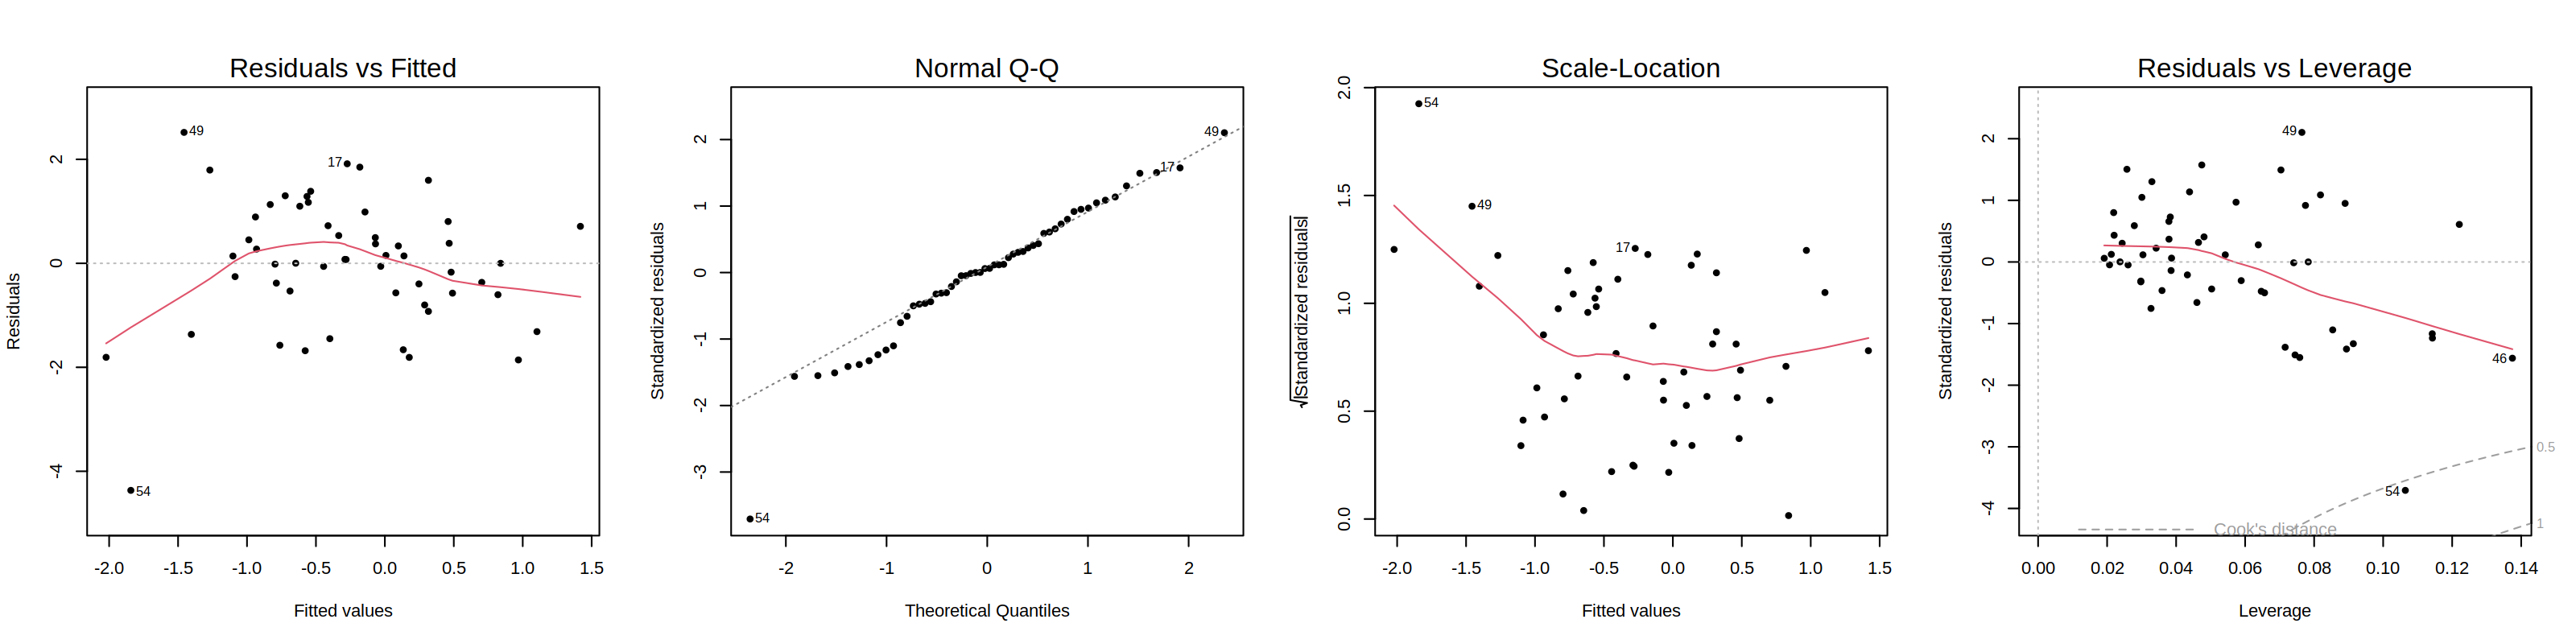

In [6]:
# diagnostic plots using normal linear model

prep_window(c(1,4))
plot(mdl_lm, which = 1)
plot(mdl_lm, which = 2)
plot(mdl_lm, which = 3)
plot(mdl_lm, which = 5)

# 2023 (point 54) has high leverage - try re-fitting without & compare parameters?

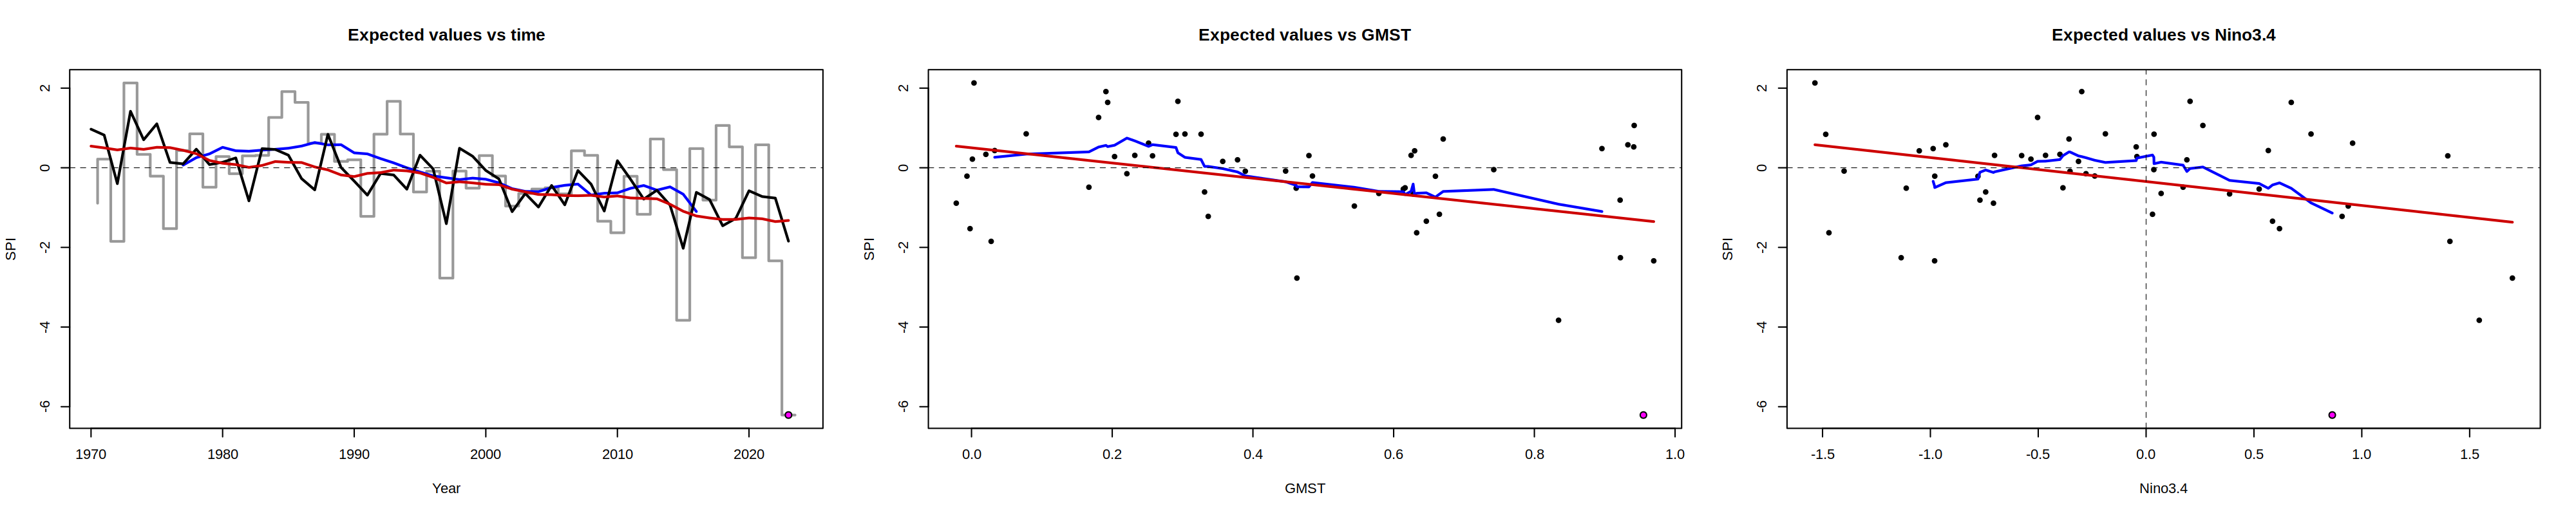

In [8]:
prep_window(c(1,5)); par(mfrow = c(1,3))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Expected values vs time")
lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

lines(df$year, ns_pars(mdl_ns)$loc, lwd = 2)
lines(df$year, predict(mdl_lm, newdata = data.frame(gmst = df$gmst, nino = 0)), lwd = 2, col = "red3") # GMST trend
points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta")

abline(h = 0, lty = 2, lwd = 0.5)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$gmst, df$spi,pch = 20, xlab = "GMST", ylab = "SPI", main = "Expected values vs GMST")
lines(df$gmst[order(df$gmst)], filter(df$spi[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

lines(df$gmst[order(df$gmst)], predict(mdl_lm, newdata = data.frame(gmst = sort(df$gmst), nino = 0)), lwd = 2, col = "red3")

abline(h = 0, lty = 2, lwd = 0.5)
points(df[df$year == 2023,c("gmst", "spi")], pch = 21, bg = "magenta")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$nino, df$spi,pch = 20, xlab = "Nino3.4", ylab = "SPI", main = "Expected values vs Nino3.4")
lines(df$nino[order(df$nino)], filter(df$spi[order(df$nino)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

lines(df$nino[order(df$nino)], predict(mdl_lm, newdata = data.frame(gmst = mean(df$gmst), nino = sort(df$nino))), lwd = 2, col = "red3")

abline(h = 0, v = 0, lty = 2, lwd = 0.5)
points(df[df$year == 2023,c("nino", "spi")], pch = 21, bg = "magenta")

---
---
# **Nonstationary model**

## **Return level plots**

In [3]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))
nino34[nino34$date == "2023-12-15","nino34"] <- nino34[nino34$date == "2023-11-15","nino34"] # dummy value until December data is available

In [39]:
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        
        # fit model and get fixed covariates
        mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)
        gmst_2023 <- df$gmst[df$year == 2023]
        nino_2023 <- df$nino[df$year == 2023]
        
        png(paste0("fig/rlplot_era5_",varnm,nm,".png"), height = 480, width = 480 * 1.5); par(cex.main = 1.4); {

            plot_returnlevels(mdl_ns, cov = data.frame(gmst = gmst_2023, nino = nino_2023), 
                              cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = nino_2023),
                              main = paste0(varnm,nm," ~ GMST + Nino",nm))
        }; dev.off()
    }
}

## **Trend plots**

In [3]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))
nino34[nino34$date == "2023-12-15","nino34"] <- nino34[nino34$date == "2023-11-15","nino34"] # dummy value until December data is available

In [45]:
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        
        # fit model and get fixed covariates
        mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)
        gmst_2023 <- df$gmst[df$year == 2023]
        nino_2023 <- df$nino[df$year == 2023]
        
        png(paste0("fig/trendplots_era5_",varnm,nm,".png"), height = 480, width = 480 * 5); par(cex.main = 1.4); {

            par(mfrow = c(1,3))
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Expected values vs time")
            lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$year, ns_pars(mdl_ns)$loc, lwd = 2)
            lines(df$year, ns_pars(mdl_ns, fixed_cov = data.frame(gmst = df$gmst, nino = 0))$loc, lwd = 2, col = "red3") # GMST trend
            points(df[df$year == 2023,c("year", "spi")], pch = 21, bg = "magenta")

            abline(h = 0, lty = 2, lwd = 0.5)
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$gmst, df$spi,pch = 20, xlab = "GMST", ylab = "SPI", main = "Expected values vs GMST")
            lines(df$gmst[order(df$gmst)], filter(df$spi[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$gmst[order(df$gmst)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = sort(df$gmst), nino = 0))$loc, lwd = 2, col = "red3")

            abline(h = 0, lty = 2, lwd = 0.5)
            points(df[df$year == 2023,c("gmst", "spi")], pch = 21, bg = "magenta")
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$nino, df$spi,pch = 20, xlab = "Nino3.4", ylab = "SPI", main = "Expected values vs Nino3.4")
            lines(df$nino[order(df$nino)], filter(df$spi[order(df$nino)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$nino[order(df$nino)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = mean(df$gmst), nino = sort(df$nino)))$loc, lwd = 2, col = "red3")

            abline(h = 0, v = 0, lty = 2, lwd = 0.5)
            points(df[df$year == 2023,c("nino", "spi")], pch = 21, bg = "magenta")
            
        }; dev.off()
    }
}

### **Trend excluding 2023**

In [47]:
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        df_2023 <- df[df$year == 2023,]
        gmst_2023 <- df_2023$gmst
        nino_2023 <- df_2023$nino
        
        # remove 2023 from model fit
        df <- df[df$year < 2023,]
        
        # fit model
        mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)
        
        png(paste0("fig/trendplots-excl2023_era5_",varnm,nm,".png"), height = 480, width = 480 * 5); par(cex.main = 1.4); {

            par(mfrow = c(1,3))
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Expected values vs time")
            lines(df$year, filter(df$spi, rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$year, ns_pars(mdl_ns)$loc, lwd = 2)
            lines(df$year, ns_pars(mdl_ns, fixed_cov = data.frame(gmst = df$gmst, nino = 0))$loc, lwd = 2, col = "red3") # GMST trend
            points(df_2023[,c("year", "spi")], pch = 21, bg = "magenta")

            abline(h = 0, lty = 2, lwd = 0.5)
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$gmst, df$spi,pch = 20, xlab = "GMST", ylab = "SPI", main = "Expected values vs GMST")
            lines(df$gmst[order(df$gmst)], filter(df$spi[order(df$gmst)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$gmst[order(df$gmst)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = sort(df$gmst), nino = 0))$loc, lwd = 2, col = "red3")

            abline(h = 0, lty = 2, lwd = 0.5)
            points(df_2023[,c("gmst", "spi")], pch = 21, bg = "magenta")
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            plot(df$nino, df$spi,pch = 20, xlab = "Nino3.4", ylab = "SPI", main = "Expected values vs Nino3.4")
            lines(df$nino[order(df$nino)], filter(df$spi[order(df$nino)], rep(1/15,15), sides = 2), col = "blue", lwd = 2)

            lines(df$nino[order(df$nino)], ns_pars(mdl_ns, fixed_cov = data.frame(gmst = mean(df$gmst), nino = sort(df$nino)))$loc, lwd = 2, col = "red3")

            abline(h = 0, v = 0, lty = 2, lwd = 0.5)
            points(df_2023[,c("nino", "spi")], pch = 21, bg = "magenta")
            
        }; dev.off()
    }
}

## **Sensitivity to 2023 observation**

In [98]:
gmst <- read.fwf("ts/gmst.dat", comment.char = "#", widths = c(5,15), col.names = c("year", "gmst"))
nino34 <- read.csv("ts/nino34_det.csv", col.names = c("date", "nino34"))
nino34[nino34$date == "2023-12-15","nino34"] <- nino34[nino34$date == "2023-11-15","nino34"] # dummy value until December data is available

In [55]:
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        
        # fit model and get fixed covariates
        mdl_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)
        gmst_2023 <- df$gmst[df$year == 2023]
        nino_2023 <- df$nino[df$year == 2023]
        
        png(paste0("fig/loo-sensitivity_era5_",varnm,nm,".png"), height = 480, width = 480 * 2); par(cex.main = 1.4); {
            loo_pars(mdl_ns, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = 0), plot = T, relative = F)
        }; dev.off()
    }
}

### **Bootstrapped results with & without 2023**

In [75]:
nsamp <- 1000
for (varnm in c("spi", "spei")) {
    for (nm in c(6,24)) {
        
        # load data & compile into single dataframe
        spi <- read.csv(paste0("ts/era5_",varnm,nm,".csv"), col.names = c("year", "spi"))
        nino_m <- filter(nino34$nino34, rep(1/nm,nm), sides = 1)
        df <- merge(merge(spi, gmst), data.frame("year" = as.integer(substr(nino34$date,1,4)), 
                                                 "nino" = nino_m)[substr(nino34$date,6,7) == "12",])
        df_2023 <- df[df$year == 2023,]
        gmst_2023 <- df_2023$gmst
        nino_2023 <- df_2023$nino
        ev_2023 <- df_2023$spi
        
        # fit standard model & write bootstrapped results to csv
        mdl_incl <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T, ev = ev_2023)
        res_incl <- boot_ci(mdl_incl, nsamp = nsamp, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = 0))
        write.csv(res_incl, paste0("res/res-incl2023_era5_",varnm,nm,".csv"))
        
        # remove 2023 from model fit & write bootstrapped results to csv
        df <- df[df$year < 2023,]
        mdl_excl <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T, ev = ev_2023)
        res_excl <- boot_ci(mdl_excl, nsamp = nsamp, cov = data.frame(gmst = gmst_2023, nino = 0), cov_cf = data.frame(gmst = gmst_2023 - 1.2, nino = 0))
        write.csv(res_excl, paste0("res/res-excl2023_era5_",varnm,nm,".csv"))
        
        res <- abind(res_incl, res_excl, along = 0)
        
        png(paste0("fig/ns-params_era5_",varnm,nm,".png"), height = 480, width = 480 * 2); par(mfrow = c(1,8), mar = c(3,3,3,1), cex.main = 1.6); {
            for (i in rownames(res_incl)[-c(5,6)]) {
                if(i == "PR") {
                    x <- 1
                } else if (!(i %in% c("sigma0", "mu0"))) {
                    x <- 0
                } else {
                    x <- NA
                }
                plot(0, type = "n", ylim = range(c(res[,i,], x), na.rm = T), xlab = "", ylab = "", main = i, xaxt = "n")
                axis(1, at = c(0.8, 1.2), labels = c("Incl", "Excl"), las = 2)
                segments(x0 = c(0.8, 1.2), y0 = res[,i,2], y1 = res[,i,3], col = adjustcolor(c("red3", "blue3"), alpha = 0.4), lwd = 5)
                points(c(0.8, 1.2), res[,i,1], pch = 21, bg = c("red3", "blue3"))
                abline(h = x, lty = 2)
            } 
        }; dev.off()
    }
}